Importing libraires

In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, Dropout, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from PIL import Image
import urllib
import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import datetime
from sklearn.utils import shuffle
from tensorflow.keras.applications import ResNet50

Visualising two images

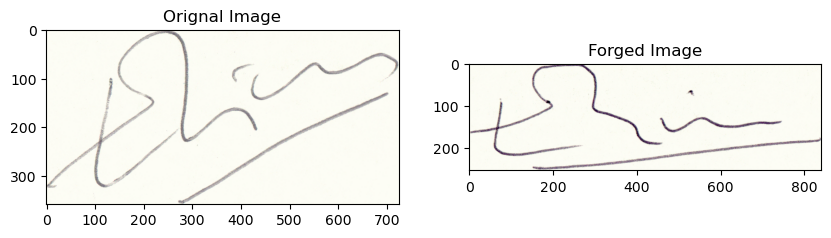

(359, 725, 3)
(255, 841, 3)


In [3]:
#reading file paths
path1 = r"C:\Users\08bur\Desktop\signature_images\sign_data\sign_data\train\001\001_01.PNG" 
path2 = r"C:\Users\08bur\Desktop\signature_images\sign_data\sign_data\train\001_forg\0201001_03.png"

#creating subplots for actual and forged image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

#reading the images from their paths
img1 = cv2.imread(path1)
img2 = cv2.imread(path2)

#plotting the images 
axes[0].imshow(img1)
axes[0].set_title('Orignal Image')

axes[1].imshow(img2)
axes[1].set_title('Forged Image')
plt.show()

#reading the shape of the images
print(img1.shape)
print(img2.shape)

Defining the read data function 

In [4]:
def read_data(dir, data):
    images1 = []  # the real one
    images2 = []  # the forged one

    labels = []
    for j in range(0, len(data)):
        path = os.path.join(dir, data.iat[j, 0])
        img1 = cv2.imread(path)
        img1 = cv2.resize(img1, (100, 100))
        images1.append([img1])

        path = os.path.join(dir, data.iat[j, 1])
        img2 = cv2.imread(path)
        img2 = cv2.resize(img2, (100, 100))
        images2.append([img2])

        labels.append(np.array(data.iat[j, 2]))

    images1 = np.array(
        images1).astype(np.float32) / 255.0
    images2 = np.array(images2).astype(np.float32) / 255.0
    labels = np.array(labels).astype(np.float32)
    return images1, images2, labels


Reading the data

In [7]:


train_dir = r"C:\Users\08bur\OneDrive\Desktop\Projects\siamese network\signature_verification_dataset\sign_data\train"
train_csv = r"C:\Users\08bur\OneDrive\Desktop\Projects\siamese network\signature_verification_dataset\sign_data\train_data.csv"
test_dir = r"C:\Users\08bur\OneDrive\Desktop\Projects\siamese network\signature_verification_dataset\sign_data\test"
test_csv= r"C:\Users\08bur\OneDrive\Desktop\Projects\siamese network\signature_verification_dataset\sign_data\test_data.csv"

#
df_train = pd.read_csv(train_csv, header=None)

df_test = pd.read_csv(test_csv, header=None)

#
test_images1, test_images2, test_labels = read_data(dir=test_dir, data=df_test)
train_images1, train_images2, train_labels = read_data(dir=train_dir, data=df_train)

#
train_images1, train_images2, train_labels = shuffle(train_images1, train_images2, train_labels)
test_images1, test_images2, test_labels = shuffle(test_images1, test_images2, test_labels)

#
size = 100
train_images1 = train_images1.reshape(-1, size, size, 3)
train_images2 = train_images2.reshape(-1, size, size, 3)
test_images1 = test_images1.reshape(-1, size, size, 3)
test_images2 = test_images2.reshape(-1, size, size, 3)

In [8]:
print(train_images1.shape, train_images2.shape)
print(test_images1.shape,  test_images2.shape)
train_labels.shape


(23206, 100, 100, 3) (23206, 100, 100, 3)
(5748, 100, 100, 3) (5748, 100, 100, 3)


(23206,)

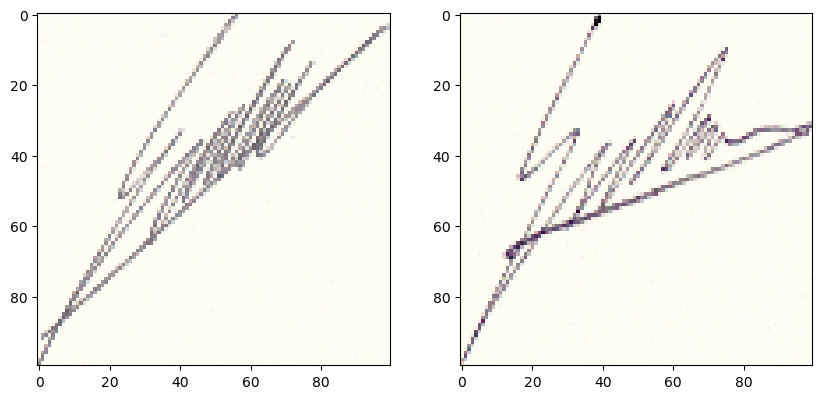

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(train_images1[1])
axes[1].imshow(train_images2[1])

In [10]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(100,100,3))
for layer in base_model.layers:
    layer.trainable = False

def custom_resnet_model():
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    return model

In [14]:
def manhattan_distance(vects):
    x,y = vects
    return K.abs((x - y))

In [15]:
# initializing the base network 
input_dim = (100, 100, 3)

base_network = custom_resnet_model()

img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

distance = Lambda(manhattan_distance)([feat_vecs_a, feat_vecs_b])

prediction = Dense(1, activation='sigmoid')(distance)

#
earlyStopping_callback = EarlyStopping(monitor='val_loss',
                              patience=3,
                              verbose=1,
                              restore_best_weights = True) 

model_3 = Model([img_a, img_b], prediction)
model_3.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 64)        │ 25,684,928 │ input_layer_5[0]… │
│ (Sequential)        │                   │            │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 64)        │          0 │ sequential_3[0][… │
│                     │                   │            │ sequential_3[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         65 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,684,993 (97.98 MB)

 Trainable params: 2,097,281 (8.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [16]:
#
model_3.compile(loss="binary_crossentropy", optimizer= "adam" 
              , metrics=["accuracy"])

#
history = model_3.fit([train_images1, train_images2], train_labels, validation_split=.30,
                    batch_size=32, verbose=1, epochs=10, callbacks= earlyStopping_callback)

Epoch 1/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 400s 761ms/step - accuracy: 0.7334 - loss: 0.5242 - val_accuracy: 0.9131 - val_loss: 0.2774
Epoch 2/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 379s 747ms/step - accuracy: 0.9196 - loss: 0.2428 - val_accuracy: 0.9519 - val_loss: 0.1596
Epoch 3/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 382s 751ms/step - accuracy: 0.9654 - loss: 0.1245 - val_accuracy: 0.9693 - val_loss: 0.1132
Epoch 4/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 407s 801ms/step - accuracy: 0.9835 - loss: 0.0714 - val_accuracy: 0.9767 - val_loss: 0.0815
Epoch 5/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 358s 706ms/step - accuracy: 0.9893 - loss: 0.0480 - val_accuracy: 0.9819 - val_loss: 0.0641
Epoch 6/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 379s 746ms/step - accuracy: 0.9955 - loss: 0.0280 - val_accuracy: 0.9661 - val_loss: 0.0973
Epoch 7/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 402s 792ms/step - accuracy: 0.9926 - loss: 0.0345 - val_accuracy: 0.9864 - val_loss: 0.0514
Epoch 8/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 392s 772ms/step - accuracy: 0.9963 -

Testing a pretrained network on the data 

In [22]:
model_3.save(r'C:\Users\08bur\OneDrive\Desktop\Projects\siamese network\resnet_siamese_model_3.h5')

In [17]:
loss, accuracy = model_3.evaluate([test_images1, test_images2], test_labels)
print(accuracy)

180/180 ━━━━━━━━━━━━━━━━━━━━ 80s 443ms/step - accuracy: 0.9971 - loss: 0.0158
0.9963465332984924
